In [1]:
# Use the VARMAX model to forecast realdpi and realcons
# Make forecasts on a one-step window over the test set. Use the last known value method as a baseline.
# Calculate the MAPE. Did the model perform better than the baseline

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

In [3]:
# Macroeconomics dataset from the United States, collected quarterly from 1959 to 2009, to forecast the real GDP
# This dataset is available with the statsmodels library

import statsmodels.api as sm

econ_data = sm.datasets.macrodata.load_pandas().data
econ_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [4]:
econ_data.describe()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,1983.876847,2.492611,7221.171901,4825.293103,1012.863862,663.328640,5310.540887,105.075788,667.927586,5.311773,5.884729,239.724153,3.961330,1.336502
std,14.686817,1.118563,3214.956044,2313.346192,585.102267,140.863655,2423.515977,61.278878,455.346381,2.803071,1.458574,37.390450,3.253216,2.668799
min,1959.000000,1.000000,2710.349000,1707.400000,259.764000,460.400000,1886.900000,28.980000,139.600000,0.120000,3.400000,177.146000,-8.790000,-6.790000
25%,1971.000000,1.500000,4440.103500,2874.100000,519.147500,527.959500,3276.950000,41.050000,228.650000,3.515000,4.900000,208.631000,2.270000,-0.085000
50%,1984.000000,2.000000,6559.594000,4299.900000,896.210000,662.412000,4959.400000,104.100000,540.900000,5.010000,5.700000,236.348000,3.240000,1.340000
75%,1996.500000,3.000000,9629.346500,6398.150000,1436.681500,773.049000,6977.850000,159.650000,1102.100000,6.665000,6.800000,271.721500,4.975000,2.630000
max,2009.000000,4.000000,13415.266000,9363.600000,2264.721000,1044.088000,10077.500000,218.610000,1673.900000,15.330000,10.700000,308.013000,14.620000,10.950000


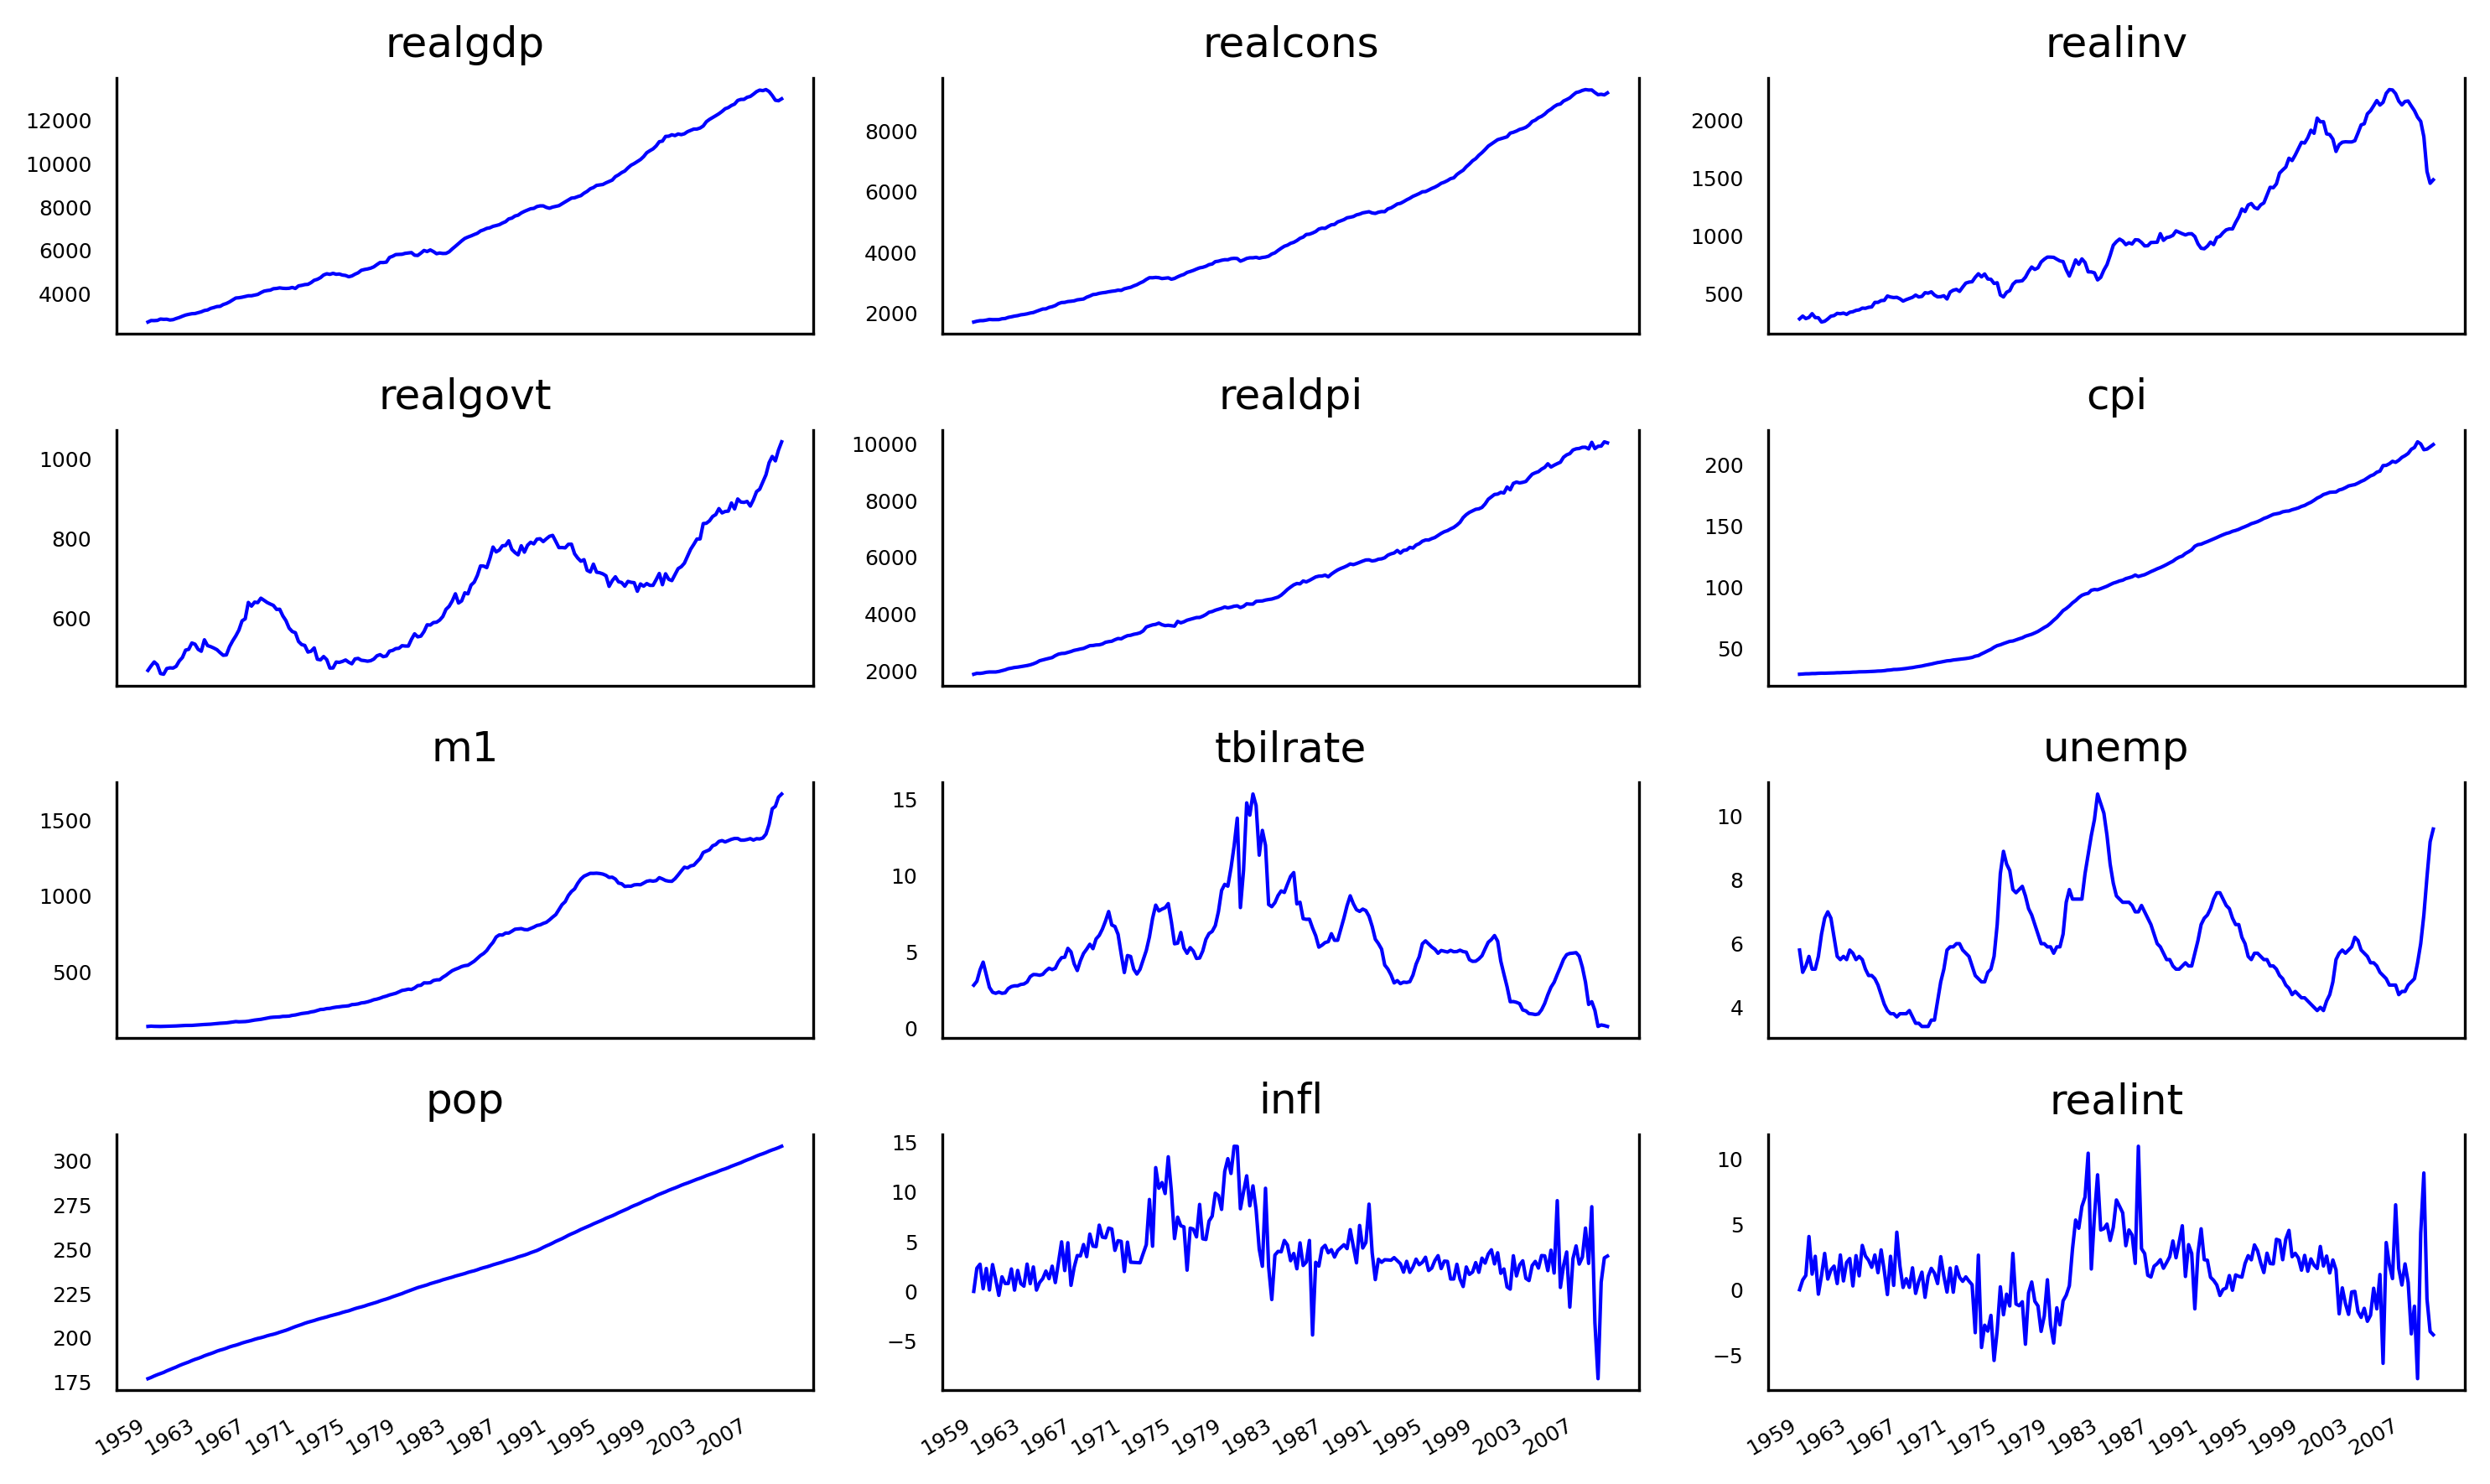

In [5]:
# Apart from the coulmns for year and quarter, all the rest are used

fig, axes = plt.subplots(nrows=4, ncols=3, dpi=300, figsize=(10,6))

# Iterate for twelve variables
for i, ax in enumerate(axes.flatten()[:12]):
    #Skip the year and quarter columns, so that we start at realgdp
    data = econ_data[econ_data.columns[i+2]]
    
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 16), xticklabels=np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [6]:
# Define the target variable i.e. realgdp
endog = econ_data[['realdpi', 'realcons']]

# Use the differenced version for modeling
endog_diff = econ_data[['realdpi', 'realcons']].diff()[1:]

# Define the exogenous variables
exog = econ_data[['realgdp','realinv','realgovt','cpi','m1','tbilrate','unemp','pop','infl','realint']]

In [7]:
# Function to fit all unique SARIMAX models

from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VARMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []

    # Iterate over each unique (p,q) combination. The use of tqdm will display a progress bar
    for order in tqdm(order_list):
        try:
            # We also specify disp=False to avoid printing convergence messages to the console
            model = VARMAX(endog, 
                            exog,
                            order=order).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
# Define the range of possible values for the orders p and q

from itertools import product

p = range(0, 4, 1)
q = range(0, 4, 1)

order_list = list(product(p, q))

In [9]:
# To train the model, we will use the first 162 instances of both the target(endogenous) and exogenous variables
import warnings
warnings.filterwarnings('ignore')

train = endog_diff[:162]
test = endog_diff[162:]

# Ensure that the index of exog_train is aligned with train
exog_train = exog[1:163]

result_df = optimize_VARMAX(train, exog_train, order_list)
result_df

,"(p, q)",AIC
0,"(1, 0)",3113.478554
1,"(2, 0)",3118.688860
2,"(0, 1)",3120.096864
3,"(1, 1)",3121.109477
4,"(3, 0)",3121.521262
5,"(0, 3)",3122.398465
6,"(0, 2)",3122.999852
7,"(1, 2)",3125.051543
8,"(2, 1)",3126.805587
9,"(1, 3)",3127.566148


In [10]:
# The results show that (p,q)=(1,0) as the lowest AIC value. 
p=1
q=0

In [11]:
# Next we use Granger causality test to test the relationship between realdpi & realcons
# Granger causality test checks if the second variable causes the first one (The test must be run both ways)
# We pass the value of p to maxlag attibute in the grangercausalitytests function
from statsmodels.tsa.stattools import grangercausalitytests

# We test if realcons Granger-causes realdpi
print('realcons Granger-causes realdpi ?\n')
print('------------------')
granger_1 = grangercausalitytests(econ_data[['realcons', 'realdpi']].diff()[1:], [p])

# We test if realdpi Granger-causes realcons
print('\nrealdpi Granger-causes realcons ?\n')
print('------------------')
granger_2 = grangercausalitytests(econ_data[['realdpi', 'realcons']].diff()[1:], [p])

realcons Granger-causes realdpi ?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=7.8540  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7045  , p=0.0055  , df=1
parameter F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1

realdpi Granger-causes realcons ?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=35.3881 , p=0.0000  , df=1
likelihood ratio test: chi2=32.5962 , p=0.0000  , df=1
parameter F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1


In [12]:
# Both the tests return a p-value smaller than 0.05. 
# Therefore, we conclude that realdpi Granger-causes realcons, and realcons Granger-causes realdpi 
# Our VARMAX(1,0) model is thus valid, move on to residual analysis. 

In [13]:
# Before tat we test if the larges order id is valid i.e. (p,q) = (3, 3)

# We test if realcons Granger-causes realdpi
print('realcons Granger-causes realdpi ?\n')
print('------------------')
granger_1 = grangercausalitytests(econ_data[['realcons', 'realdpi']].diff()[1:], [3])

# We test if realdpi Granger-causes realcons
print('\nrealdpi Granger-causes realcons ?\n')
print('------------------')
granger_2 = grangercausalitytests(econ_data[['realdpi', 'realcons']].diff()[1:], [3])

realcons Granger-causes realdpi ?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3

realdpi Granger-causes realcons ?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3


In [14]:
# the largest order (p,q)=(3,3) is also valid because Granger returns p-values less than 0.05 in both directions

In [15]:
# We revert to our best AIC value and fit the VARMAX(1,0) model on our train setbest

best_model = VARMAX(train, exog_train, order=(p,q))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                             VARX(1)   Log Likelihood               -1527.739
                               + intercept   AIC                           3113.479
Date:                     Thu, 19 Oct 2023   BIC                           3203.019
Time:                             12:32:41   HQIC                          3149.833
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.08, 0.29   Jarque-Bera (JB):         40.65, 18.60
Prob(Q):                        0.78, 0.59   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         5.81, 2.63   Skew:                      0.12

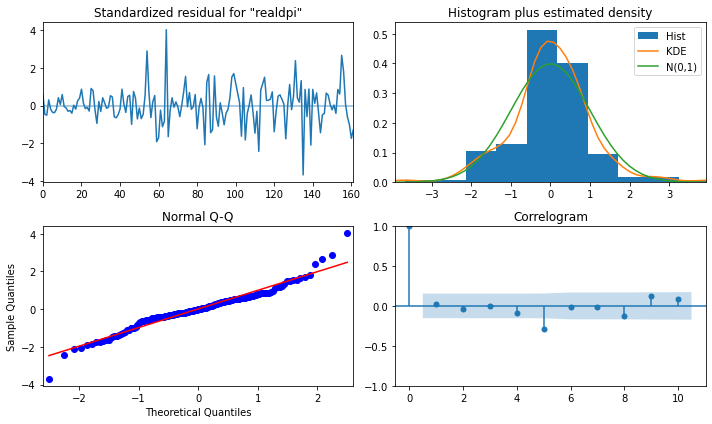

In [16]:
# We plot histograms of the residuals, the Q-Q plot & correlogram
# The residuals of the two variables are studied separately i.e. pass different values (0,1) for the "variable" parameter

best_model_fit.plot_diagnostics(figsize=(10,6), variable=0)
plt.tight_layout()

In [17]:
# Residuals analysis of realdpi. 
# The standardized residuals seem to have no trend and constant variance, which is in line with white noise. 
# The histogram also closely resembles the shape of a normal distribution. 
# The Q-Q plot supports this with a fairly straight line that lies on y = x, though we see some curvature at the extremities. 
# Finally, the correlogram shows no significant coefficients except at lag 5. However, this is likely due to chance, 
# since there are no preceding significant coefficients. 

#Thus, we can conclude that the residuals are close to white noise

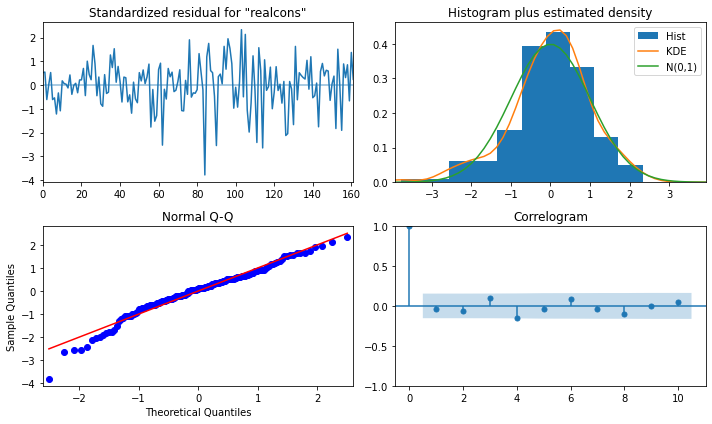

In [18]:
best_model_fit.plot_diagnostics(figsize=(10,6), variable=1)
plt.tight_layout()

In [19]:
# Residuals analysis of realcons. 
# The top-left plot shows the residuals over time - there is no trend and constant variance (behavior of white noise).
# At the top right, the distribution is very close to a normal distribution. 
# Q-Q plot at the bottom left supports this with a fairly straight line that lies on y = x. 
# Finally, the correlogram shows that there is no significant autocorrelation coefficients after lag 0 except for lag 3.
# Therefore, the residuals are close to white noise.

In [20]:
# Next we perform quantitative analysis using the Ljung-Box test to if the residuals are independent and uncorrelated
# The test must be applied on both realdpi and realcons
from statsmodels.stats.diagnostic import acorr_ljungbox

realdpi_residuals = best_model_fit.resid['realdpi']

realdpi_pvalue = acorr_ljungbox(realdpi_residuals, np.arange(1, 11, 1), return_df=True)
realdpi_pvalue.columns = ['stat','p-value']
realdpi_pvalue

,stat,p-value
1,0.075852,0.782999
2,0.410878,0.814290
3,0.411432,0.937871
4,1.786817,0.774893
5,16.201097,0.006293
6,16.266712,0.012392
7,16.307532,0.022451
8,19.254974,0.013554
9,21.970168,0.008974
10,23.465730,0.009152


In [21]:
# The p-values returned are all greater than 0.05, 
# meaning that the residuals are not correlated and are independent, just like white noise

In [22]:
realcons_residuals = best_model_fit.resid['realcons']

realcons_pvalue = acorr_ljungbox(realcons_residuals, np.arange(1,11,1), return_df=True)
realcons_pvalue.columns = ['stat', 'p-value']
realcons_pvalue

,stat,p-value
1,0.266405,0.605754
2,2.018774,0.364442
3,6.832882,0.077420
4,9.590095,0.047929
5,11.190506,0.047731
6,13.392151,0.037214
7,13.693102,0.056917
8,17.968949,0.021460
9,17.969399,0.035530
10,18.220139,0.051362


In [23]:
# The p-values returned are greater than 0.05 only up lag 2 and from lag 3 onwards, there appears to be some correlation.
# Might this be due to chance ? Meaning that the residuals are not correlated and are independent, just like white noise
# The model has passed the qualitative aspects of residual analysis but not the quantitative.


In [24]:
# Next we forecast realcons and realdpi using a VARMAX(1,0) model (our baseline will be the last observed value)
# We forecast 1 steps into the future due to exogenous variables (equivalent to forecasting one full year)

In [25]:
# Function for rolling forecasts over a test set

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VARMAX':
        # Initialize two empty lists to hold the predictions for realdpi and realcons
        realdpi_pred_VARMAX = []
        realcons_pred_VARMAX = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], exog[:i], order=(1,0))
            res = model.fit(disp=False)
            
            # Use the exogenous variable to generate predictions
            predictions = res.get_prediction(0, i + window - 1, exog=exog.iloc[-1])    
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMAX.extend(oos_pred_realdpi)
            realcons_pred_VARMAX.extend(oos_pred_realcons)
        
        #Return both lists of predictions for realdpi and realcons
        return realdpi_pred_VARMAX, realcons_pred_VARMAX
    
    elif method == 'last':
        #For the baseline, we’ll also use two lists to hold the predictions for each variable and return them at the end
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))

        return realdpi_pred_last, realcons_pred_last


In [26]:
TRAIN_LEN = len(train)
HORIZON = len(test)

# Like SARIMAX model, we can only predict the next timestep, since we have exogenous variables
WINDOW = 1

exog = exog[1:]

print(TRAIN_LEN)
print(HORIZON)



162
40


In [27]:
# Now produce the forecasts for realdpi and realcons using the VARMAX(1,0) model

realdpi_pred_VARMAX, realcons_pred_VARMAX = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')

In [28]:
# We were using stationery data to perform forecasts. 
# Now use the cumulative sum to integrate them and bring them back to the original scale of the data

test = endog[163:]

test['realdpi_pred_VARMAX'] = pd.Series()
test['realcons_pred_VARMAX'] = pd.Series()

# Integrate the forecasts using the cumulative sum
test['realdpi_pred_VARMAX'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMAX)
test['realcons_pred_VARMAX'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMAX)
test.head()

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX
163,7887.7,7389.2,7968.314836,7273.368036
164,8053.4,7501.3,8098.700615,7282.122749
165,8135.9,7571.8,8108.561899,7278.914809
166,8222.3,7645.9,8145.714468,7325.285264
167,8234.6,7713.5,8197.350122,7406.083708


In [29]:
# Next Use rolling_forecast to obtain the baseline predictions using the last known value

realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test.head()

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7968.314836,7273.368036,7716.0,7199.9
164,8053.4,7501.3,8098.700615,7282.122749,7765.9,7286.4
165,8135.9,7571.8,8108.561899,7278.914809,7887.7,7389.2
166,8222.3,7645.9,8145.714468,7325.285264,8053.4,7501.3
167,8234.6,7713.5,8197.350122,7406.083708,8135.9,7571.8


In [30]:
test.describe()

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX,realdpi_pred_last,realcons_pred_last
count,40.000000,40.00000,40.000000,40.000000,40.000000,40.000000
mean,9135.072500,8548.23500,11498.474306,11580.777733,9019.167500,8449.267500
std,665.749342,640.10207,2706.891478,3503.805466,696.668941,680.995442
min,7887.700000,7389.20000,7968.314836,7273.368036,7716.000000,7199.900000
25%,8624.800000,7987.67500,9146.839217,8369.590626,8459.750000,7899.425000
50%,9182.750000,8605.00000,10975.182165,11083.186278,9070.450000,8460.400000
75%,9827.650000,9190.57500,13579.779063,14325.620229,9694.075000,9113.425000
max,10077.500000,9363.60000,16592.446339,18640.248669,10059.000000,9363.600000


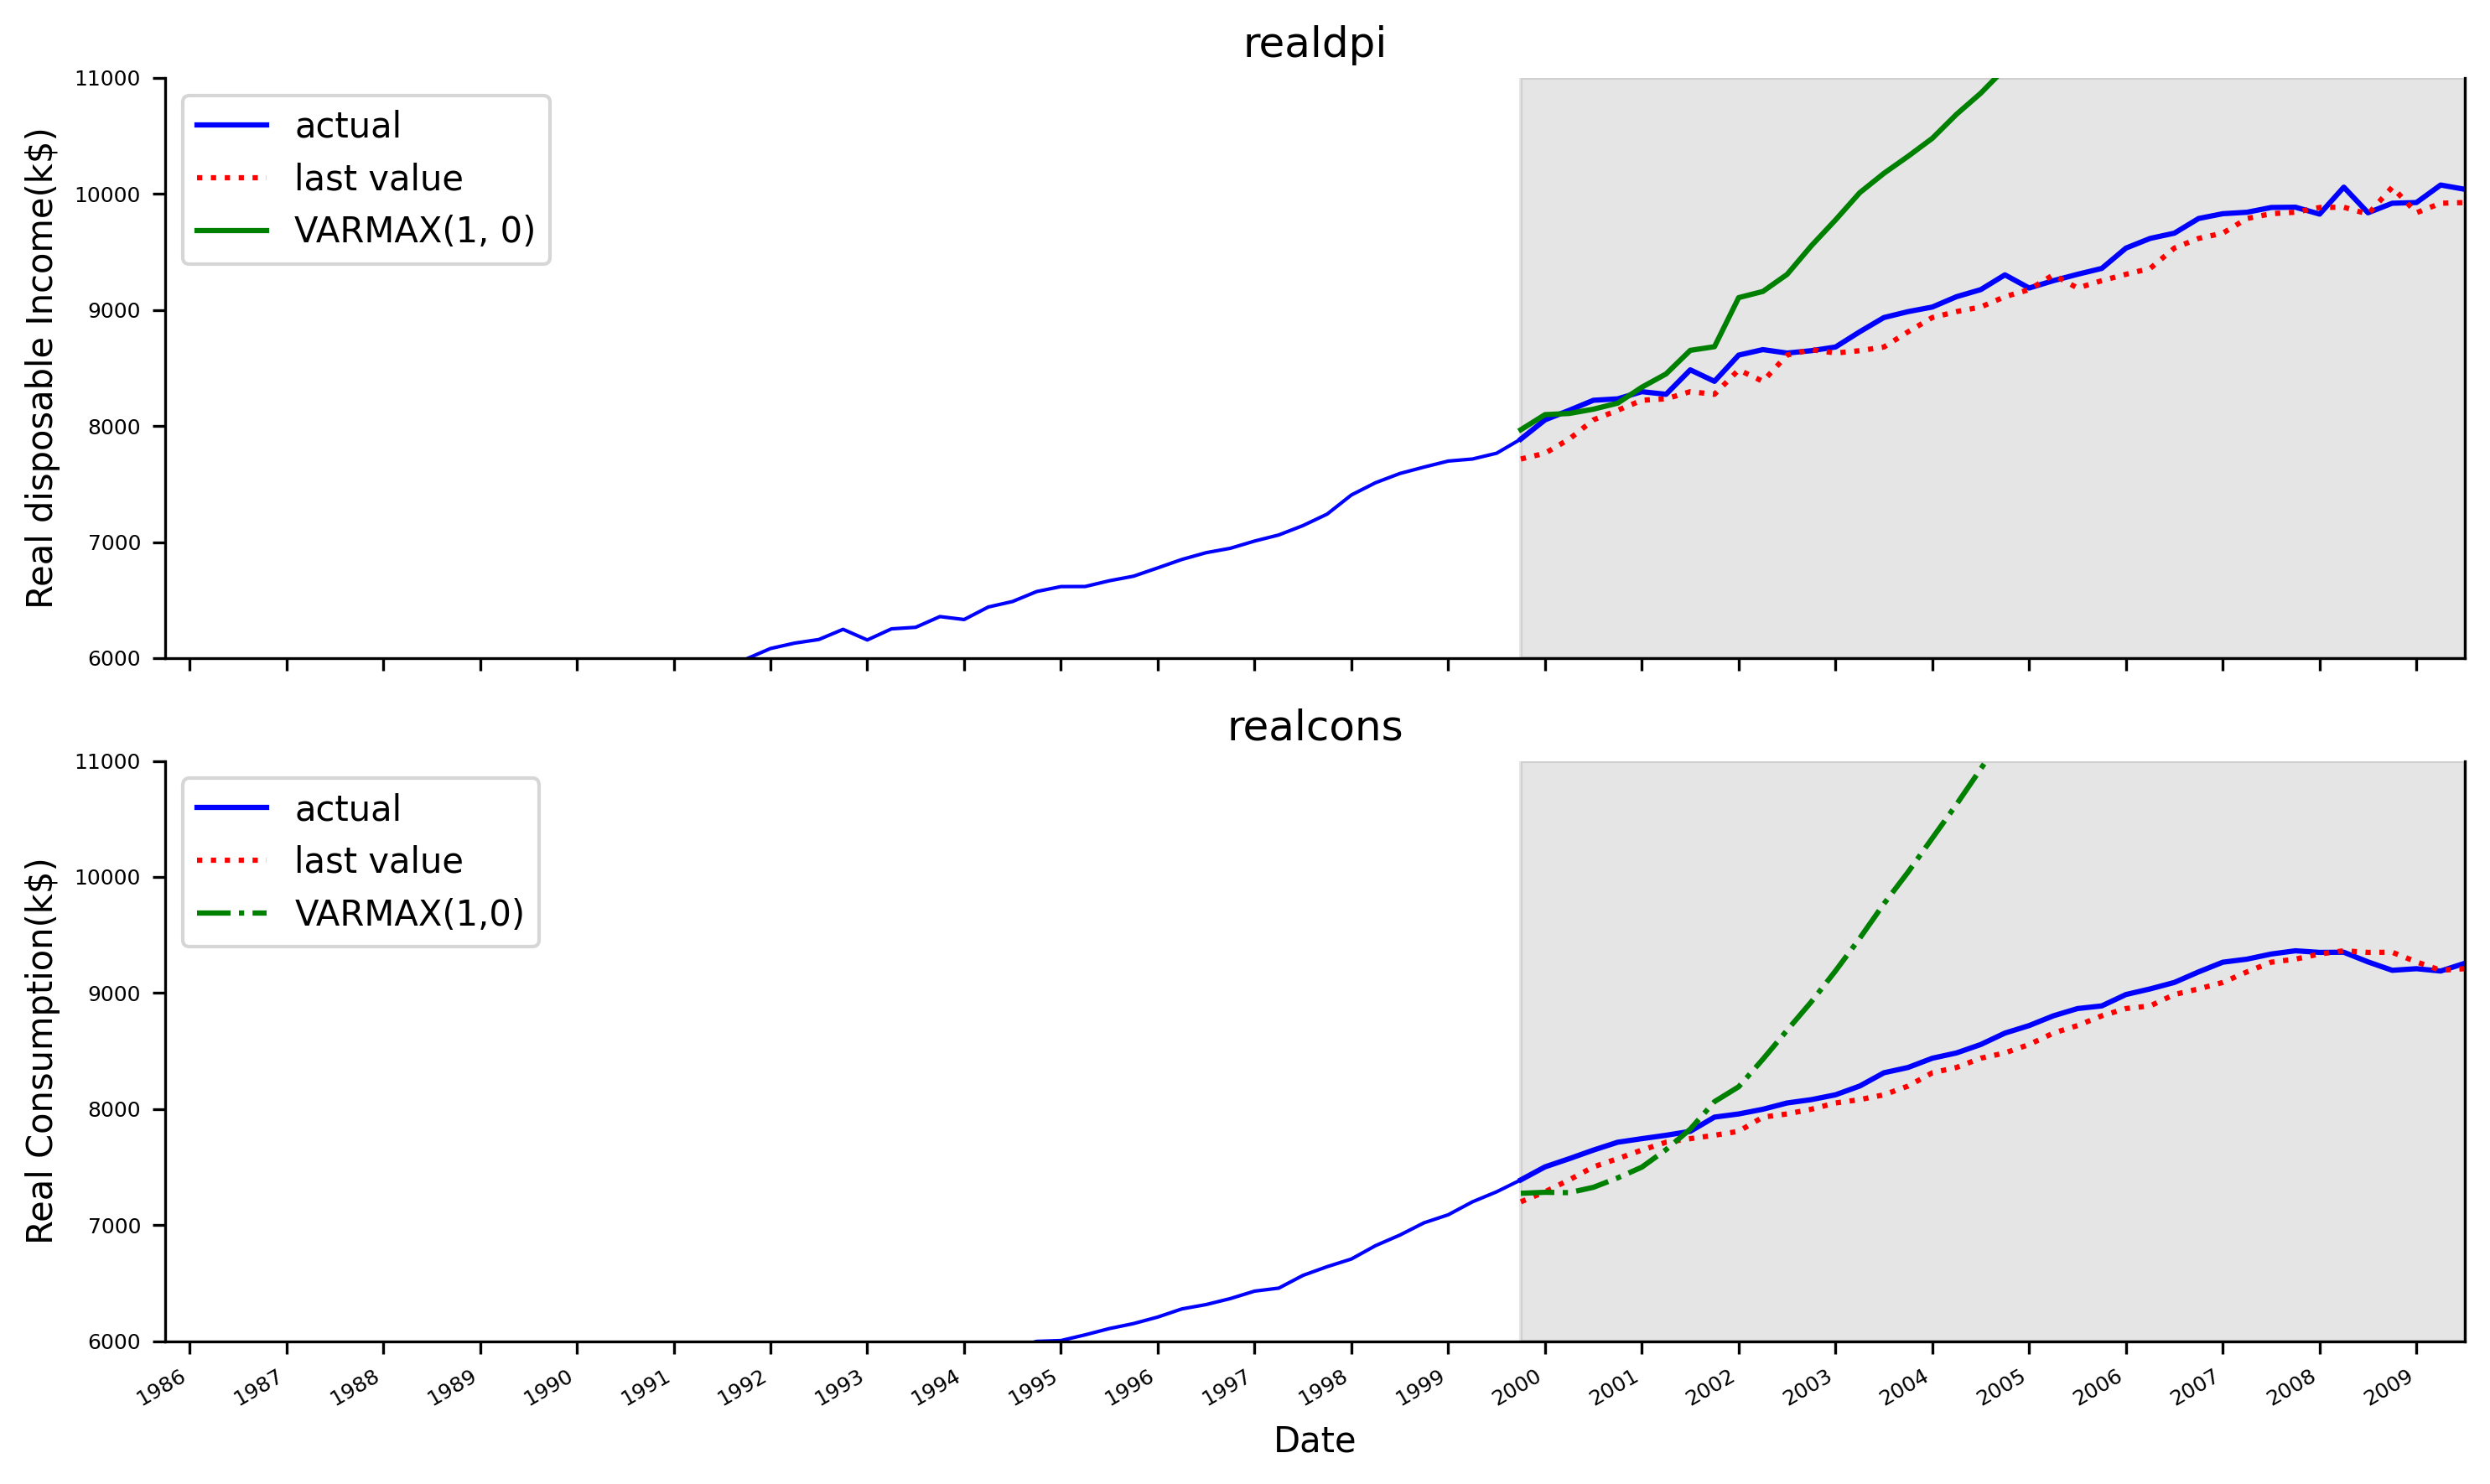

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, dpi=300, figsize=(10,6))

ax1.plot(econ_data['realdpi'][:197], color='blue', linewidth=1)
ax1.plot(test['realdpi'], 'b-', label='actual')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last value')
ax1.plot(test['realdpi_pred_VARMAX'], 'g-', label = 'VARMAX(1, 0)')

ax1.set_title("realdpi")
ax1.set_xlabel("Date")
ax1.set_ylabel("Real disposable Income(k$)")
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)

ax1.legend(loc=2)

ax2.plot(econ_data['realcons'][:197], color='blue', linewidth=1)
ax2.plot(test['realcons'], 'b-', label='actual')
ax2.plot(test['realcons_pred_last'], 'r:', label='last value')
ax2.plot(test['realcons_pred_VARMAX'], 'g-.', label='VARMAX(1,0)')

ax2.set_title("realcons")
ax2.set_xlabel("Date")
ax2.set_ylabel("Real Consumption(k$)")
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)

ax2.legend(loc=2)

plt.xticks(np.arange(0, 202, 4), np.arange(1959, 2010, 1))

ax1.set_xlim(107, 202)
ax1.set_ylim(6000, 11000)

ax2.set_xlim(107, 202)
ax2.set_ylim(6000, 11000)

fig.autofmt_xdate()
plt.tight_layout()


In [32]:
# function to compute the MAPE - Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
# compute the MAPE
mape_realdpi_VARMAX = mape(test['realdpi'], test['realdpi_pred_VARMAX'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])
print("realdpi", mape_realdpi_VARMAX, mape_realdpi_last)

mape_realcons_VARMAX = mape(test['realcons'], test['realcons_pred_VARMAX'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])
print("realcons", mape_realcons_VARMAX, mape_realcons_last)

realdpi 24.568468232859463 1.427050858761135
realcons 34.43423252961985 1.3671894266309053


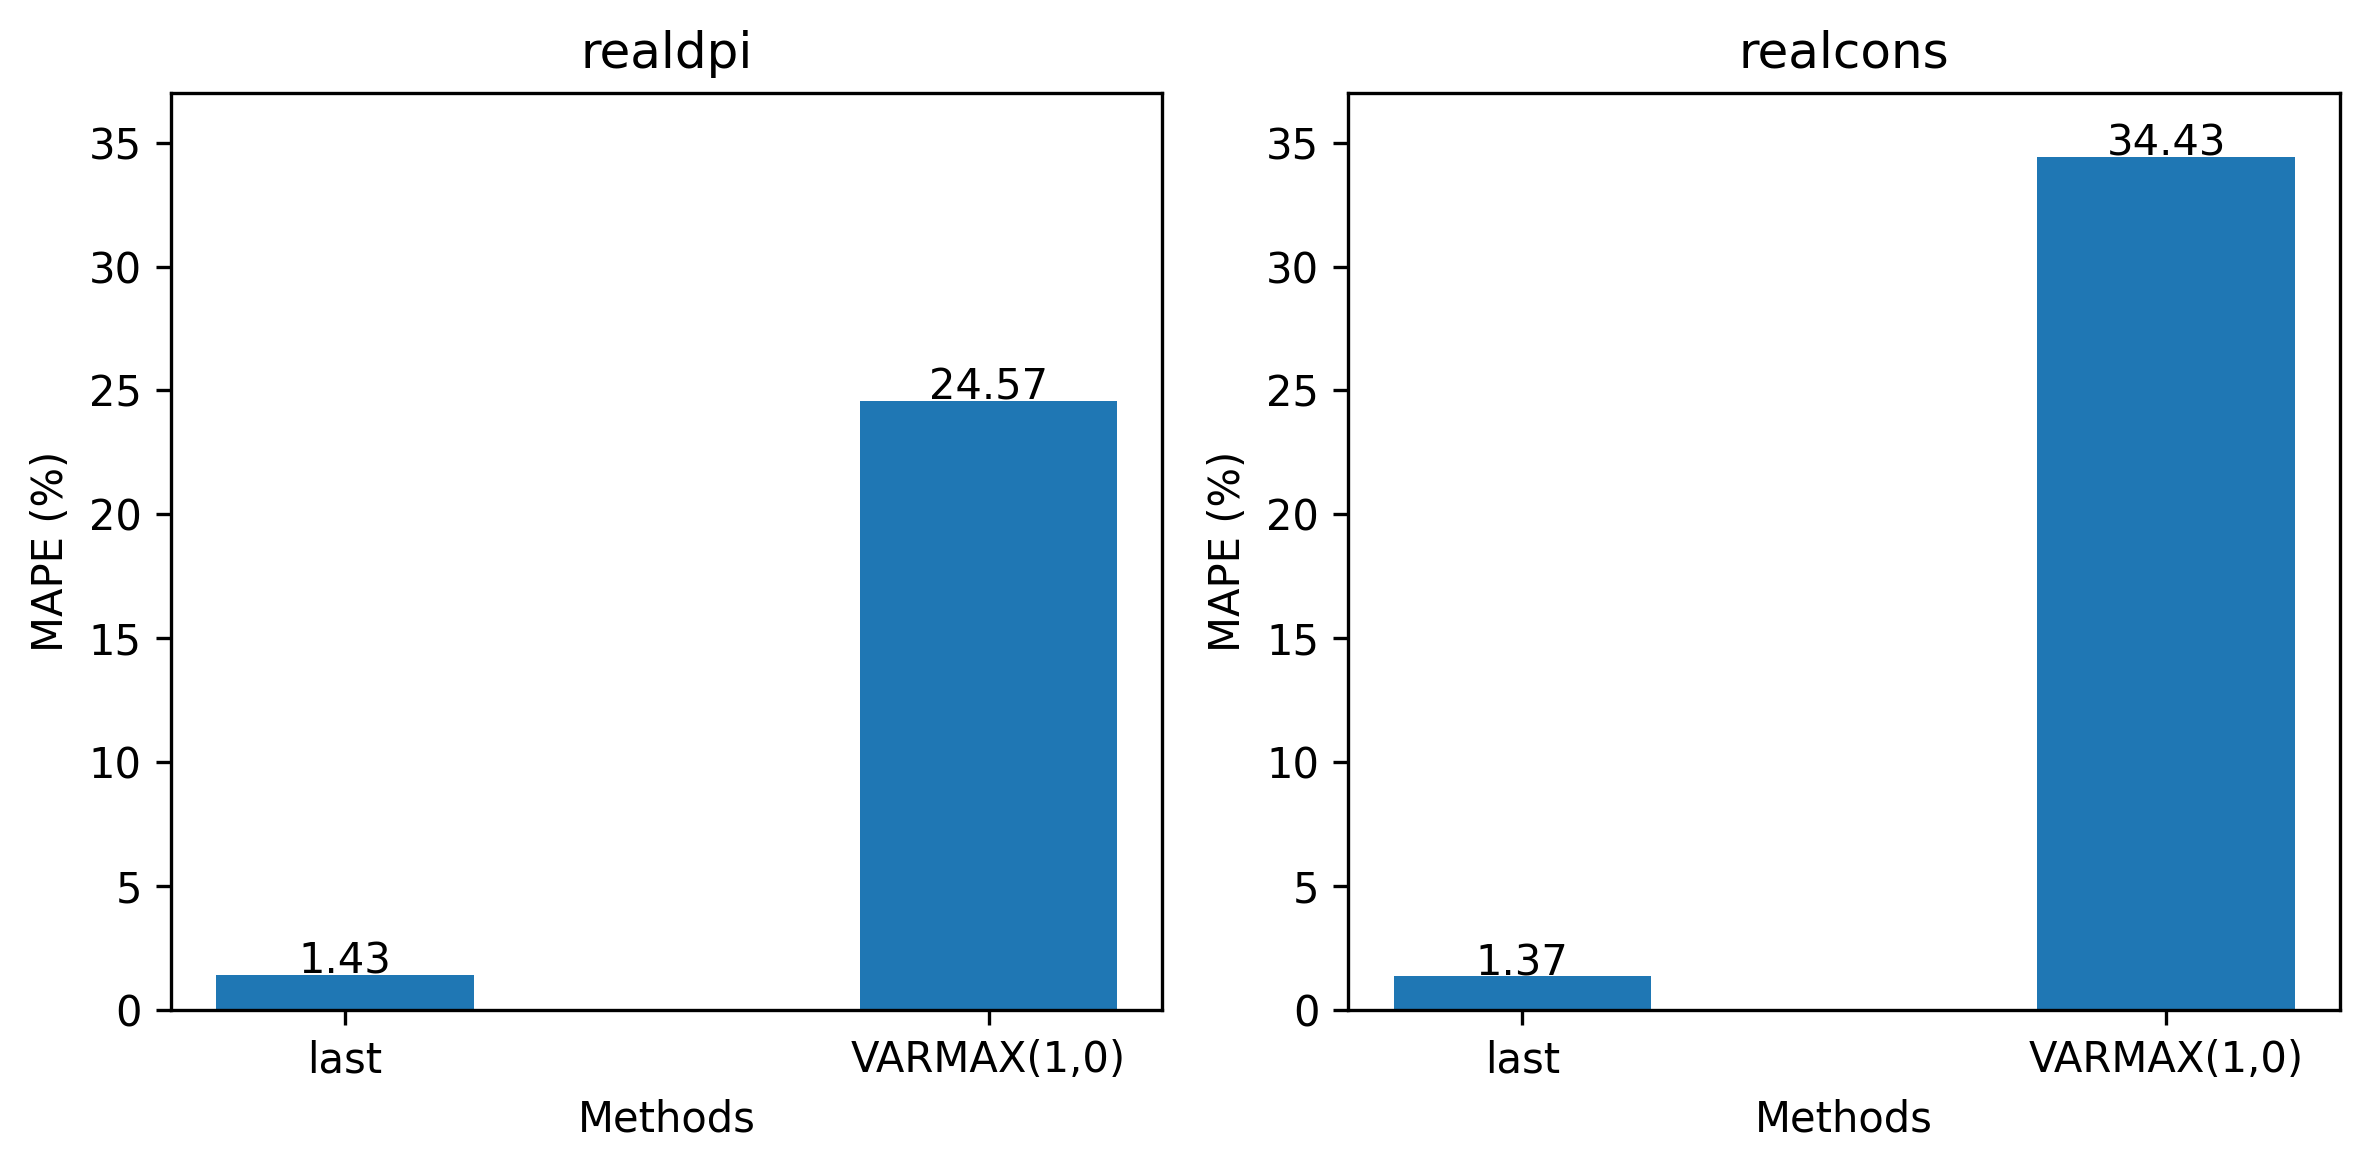

In [34]:
# Visualize which model has the lowest mean absolute percentage error (MAPE).
fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=300, figsize=(8, 4))

x1 = ['last', 'VARMAX(1,0)']
y1 = [mape_realdpi_last, mape_realdpi_VARMAX]

ax1.bar(x1, y1, width=0.4)
ax1.set_title('realdpi')
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_ylim(0, 37)

# Display the MAPE as text in the bar plot
for index, value in enumerate(y1):
    ax1.text(x=index, y=value +0.05, s=str(round(value, 2)), ha='center')

x2 = ['last', 'VARMAX(1,0)']
y2 = [mape_realcons_last, mape_realcons_VARMAX]

ax2.bar(x2, y2, width=0.4)
ax2.set_title('realcons')
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_ylim(0, 37)

# Display the MAPE as text in the bar plot
for index, value in enumerate(y2):
    ax2.text(x=index, y=value +0.05, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [35]:
# VARMAX(1,0) is clearly inappropriate for forecasting realdpi or realcons in this case.

In [36]:
# Record end time

end = dt.now()
elapsed = end - start
print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:07:29
